# Bayesian Multiobjective Optimization
*Joachim van der Herten, Ivo Couckuyt*

## Introduction

This notebook demonstrates the multiobjective optimization of an analytical function using the hypervolume-based probability of improvement function.

In [2]:
%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt

import GPflow
import GPflowOpt
import numpy as np

First we set up the objective functions (the Veldhuizen and Lamont multiobjective optimization problem 2 [vlmop2]). The vlmop2 function is a very easy problem. Ideal for illustrating Bayesian multiobjective optimization.

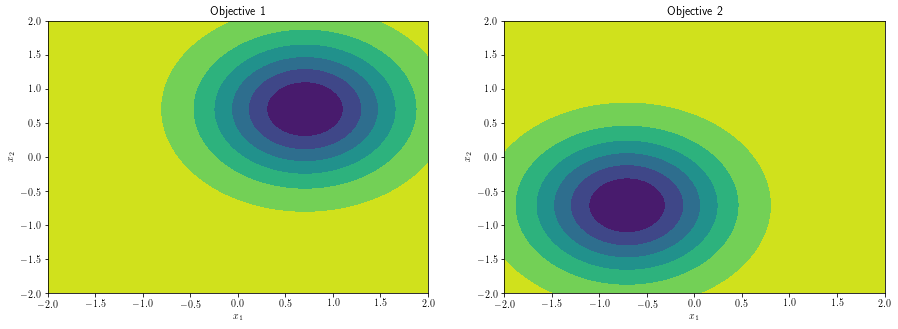

In [3]:
# Objective
def vlmop2(x):
    transl = 1 / np.sqrt(2)
    part1 = (x[:, [0]] - transl) ** 2 + (x[:, [1]] - transl) ** 2
    part2 = (x[:, [0]] + transl) ** 2 + (x[:, [1]] + transl) ** 2
    y1 = 1 - np.exp(-1 * part1)
    y2 = 1 - np.exp(-1 * part2)
    return np.hstack((y1, y2))

# Setup input domain
domain = GPflowOpt.domain.ContinuousParameter('x1', -2, 2) + \
         GPflowOpt.domain.ContinuousParameter('x2', -2, 2)

# Plot
def plotfx():  
    X = GPflowOpt.design.FactorialDesign(101, domain).generate()
    Z = vlmop2(X)
    shape = (101, 101)
    
    axes = []
    plt.figure(figsize=(15, 5))
    for i in range(Z.shape[1]):
        axes = axes + [plt.subplot2grid((1, 2), (0, i))]

        axes[-1].contourf(X[:,0].reshape(shape), X[:,1].reshape(shape), Z[:,i].reshape(shape))
        axes[-1].set_title('Objective {}'.format(i+1))
        axes[-1].set_xlabel('$x_1$')
        axes[-1].set_ylabel('$x_2$')
        axes[-1].set_xlim([domain.lower[0], domain.upper[0]])
        axes[-1].set_ylim([domain.lower[1], domain.upper[1]])
    
    return axes

plotfx();

## Multiobjective acquisition function

We can model the belief of each objective by one GP prior or model each objective separately using a GP prior. We illustrate the latter approach here. A set of data points arranged in a Latin Hypercube is evaluated on the vlmop2 function.

In multiobjective optimization the definition of improvement is ambigious. Here we define improvement using the contributing hypervolume and it ultimately determines the density and uniformity of the identified Pareto front. The hypervolume-based probability of improvement is based on the model(s) of the objective functions (vlmop2) and aggregates all the information in one cost function which is a balance between

- improving our belief of the objectives (high uncertainty)
- favoring points improving (large contributing hypervolume with potentially a higher uncertainty)
- focussing on augmenting the Pareto front (small contributing hypervolume but with low uncertainty). 

In [4]:
# Initial evaluations
design = GPflowOpt.design.LatinHyperCube(11, domain)
X = design.generate()
Y = vlmop2(X)

# One model for each objective
objective_models = [GPflow.gpr.GPR(X.copy(), Y[:,[i]].copy(), GPflow.kernels.Matern52(2, ARD=True)) for i in range(Y.shape[1])]
for model in objective_models:
    model.likelihood.variance = 0.01

hvpoi = GPflowOpt.acquisition.HVProbabilityOfImprovement(objective_models)

## Running the Bayesian optimizer

The optimization surface of multiobjective acquisition functions can be even more challenging than, e.g., standard expected improvement. Hence, a hybrid optimization scheme is preferred: a Monte Carlo optimization step first, then optimize the point with the best value.

We then run the Bayesian Optimization and allow it to select up to 20 additional decisions. 

In [6]:
# First setup the optimization strategy for the acquisition function
# Combining MC step followed by L-BFGS-B
acquisition_opt = GPflowOpt.optim.StagedOptimizer([GPflowOpt.optim.MCOptimizer(domain, 1000), 
                                                   GPflowOpt.optim.SciPyOptimizer(domain)])

# Then run the BayesianOptimizer for 20 iterations
optimizer = GPflowOpt.BayesianOptimizer(domain, hvpoi, optimizer=acquisition_opt)
with optimizer.silent():
    result = optimizer.optimize([vlmop2], n_iter=20)

print(result)

     fun: array([[ 0.89026531,  0.24293158],
       [ 0.63212056,  0.63212056],
       [ 0.77740781,  0.45153434],
       [ 0.36533437,  0.82775774],
       [ 0.09721869,  0.94073427],
       [ 0.02756077,  0.96532263],
       [ 0.53277862,  0.72620558],
       [ 0.23230157,  0.89643276],
       [ 0.94408914,  0.09070062],
       [ 0.83233952,  0.35688757],
       [ 0.72583283,  0.53502404],
       [ 0.9773906 ,  0.01051181],
       [ 0.48099383,  0.75757911],
       [ 0.00143733,  0.98415547],
       [ 0.27244878,  0.87308971],
       [ 0.67620567,  0.58745906],
       [ 0.91838872,  0.16599301],
       [ 0.86220361,  0.29578282],
       [ 0.57998635,  0.68080399],
       [ 0.42483673,  0.79366878]])
 message: 'OK'
    nfev: 20
 success: True
       x: array([[-0.26775474, -0.41509406],
       [ 0.        ,  0.        ],
       [-0.17807499, -0.14075356],
       [ 0.21559915,  0.24550388],
       [ 0.466847  ,  0.49603766],
       [ 0.59937791,  0.57927023],
       [ 0.16628713,  0.02

For multiple objective functions the returned `OptimizeResult` object contains the identified Pareto set. 

## Plotting the results

Lets plot the belief of the final models and acquisition function.

name.kern.lengthscales transform:+ve prior:None
[ 0.57354961  0.58456292]
name.kern.variance transform:+ve prior:None
[ 3.91689253]
name.likelihood.variance transform:+ve prior:None
[  1.00000004e-06]

name.kern.lengthscales transform:+ve prior:None
[ 0.59112144  0.57841926]
name.kern.variance transform:+ve prior:None
[ 3.29914908]
name.likelihood.variance transform:+ve prior:None
[  1.00000006e-06]



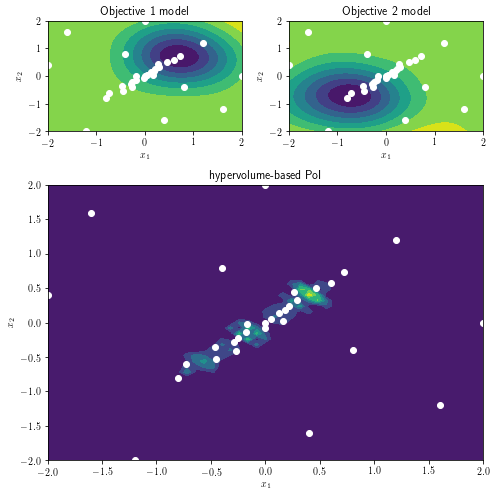

In [12]:
def plot():
    grid_size = 51  # 101
    shape = (grid_size, grid_size)
    
    Xeval = GPflowOpt.design.FactorialDesign(grid_size, domain).generate()
    
    Yeval_1, _ = hvpoi.models[0].predict_f(Xeval)
    Yeval_2, _ = hvpoi.models[1].predict_f(Xeval)
            
    Yevalc = hvpoi.evaluate(Xeval)
    
    plots = [((0,0), 1, 1, 'Objective 1 model', Yeval_1[:,0]),
             ((0,1), 1, 1, 'Objective 2 model', Yeval_2[:,0]),
             ((1,0), 2, 2, 'hypervolume-based PoI', Yevalc)]

    plt.figure(figsize=(7,7))
    for i, (plot_pos, plot_rowspan, plot_colspan, plot_title, plot_data) in enumerate(plots):
        data = hvpoi.data[0]
            
        ax = plt.subplot2grid((3, 2), plot_pos, rowspan=plot_rowspan, colspan=plot_colspan)
        ax.contourf(Xeval[:,0].reshape(shape), Xeval[:,1].reshape(shape), plot_data.reshape(shape))
        ax.scatter(data[:,0], data[:,1], c='w')
        ax.set_title(plot_title)
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_xlim([domain.lower[0], domain.upper[0]])
        ax.set_ylim([domain.lower[1], domain.upper[1]])
    plt.tight_layout()
    
# Plot representing the model belief, and the belief mapped to EI and PoF
plot()

for model in objective_models:
    print(model)

Finally, we can extract and plot the Pareto front ourselves using the `non_dominated_sort` function of the `pareto` module on the final data matrix Y.

It returns the Pareto set (non-dominated solutions) as well as a dominance vector which indicates by how many points each point is dominated by. For example, we could only select the points with dom == 1, or dom == 0 (the non-dominated solutions). Here we choose to use the dominance vector to color the points.

R: [ 1.5  1.5]
Hypervolume indicator: 1.55990422492


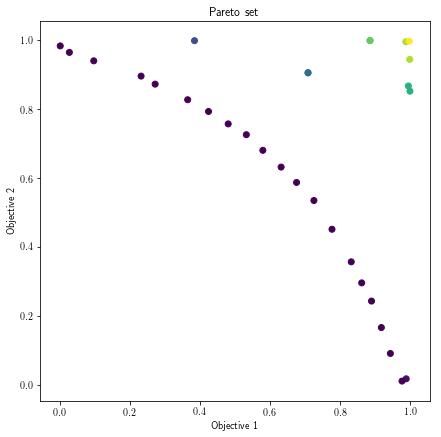

In [23]:
# plot pareto front
plt.figure(figsize=(9, 4))

R = np.array([1.5, 1.5])
print('R:', R)
hv = hvpoi.pareto.hypervolume(R)
print('Hypervolume indicator:', hv)

plt.figure(figsize=(7, 7))

pf, dom = GPflowOpt.pareto.non_dominated_sort(hvpoi.data[1])

plt.scatter(hvpoi.data[1][:,0], hvpoi.data[1][:,1], c=dom)
plt.title('Pareto set')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')